In [20]:

"""
Created on Sat Nov 16 12:48:25 2024

@author: Hanze Fu
"""

import geopandas as gpd
import rasterio
import pandas as pd
from rasterio.sample import sample_gen
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

#import plotly.express as px
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import shap
import seaborn as sns
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error, r2_score
import xgboost

np.random.seed(1)

In [10]:
point_sr= gpd.read_file("Andes_intrusions_Cenozo.shp") #Read felsic intrusion with cooling ages <= 66 Ma

point_sr.columns

Index(['id', 'Longitude', 'Latitude', 'Elevation', 'Age', 'sigma_1', 'System',
       'Formation', 'Focal_AlOH', 'Focal_MgOH', 'Focal_T_de', 'focal_Al_1',
       'Focal_MI2', 'Focal_QI3', 'ratios', 'RockType', 'Tectonomor', 'Country',
       'Reference', 'Sample_nam', 'erate', 'analyze', 'ele', 'Paleo_T',
       'Paleo_P', 'T_grad', 'P_grad', 'PT', 'PP', 'slab_dip', 'slab_dep',
       'slab_str', 'slab_thk', 'ksn', 'slope', 'relief', 'Paleo_e', 'e_grad',
       'crust', 'ana_2', 'vs_70', 'geometry'],
      dtype='object')

In [11]:
cor_df = pd.DataFrame(index = ['Slab-dip',
'Slab-dep', 'Slab-str', 'Slab-thk', 'Paleo-T', 'Paleo-P', 'T-grad',
'P-grad', 'T', 'P', 'ksn', 'slope', 'relief', 'E_grad', 'Crust', 'vs_70'], columns = ['correlation'])

point_sr.ratios = (point_sr['focal_Al_1']*point_sr['Focal_T_de'])/(point_sr['Focal_MgOH']*point_sr['Focal_MI2'])

point_sr['E_grad'] = point_sr['ele'] - point_sr['Paleo_e']
point_sr.columns

Index(['id', 'Longitude', 'Latitude', 'Elevation', 'Age', 'sigma_1', 'System',
       'Formation', 'Focal_AlOH', 'Focal_MgOH', 'Focal_T_de', 'focal_Al_1',
       'Focal_MI2', 'Focal_QI3', 'ratios', 'RockType', 'Tectonomor', 'Country',
       'Reference', 'Sample_nam', 'erate', 'analyze', 'ele', 'Paleo_T',
       'Paleo_P', 'T_grad', 'P_grad', 'PT', 'PP', 'slab_dip', 'slab_dep',
       'slab_str', 'slab_thk', 'ksn', 'slope', 'relief', 'Paleo_e', 'e_grad',
       'crust', 'ana_2', 'vs_70', 'geometry', 'E_grad'],
      dtype='object')

(array([38., 44., 31., 51., 39., 25., 21.,  9.,  2.,  3.]),
 array([  2.29296199,  12.59234973,  22.89173747,  33.19112521,
         43.49051295,  53.78990069,  64.08928843,  74.38867617,
         84.68806391,  94.98745165, 105.28683939]),
 <BarContainer object of 10 artists>)

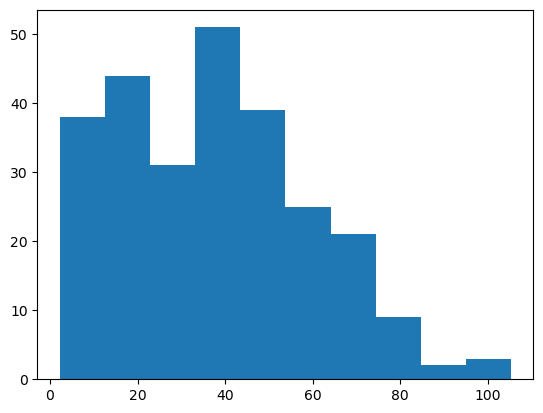

In [12]:
plt.hist(point_sr['ratios'])

In [13]:
point_sr.head()

,id,Longitude,Latitude,Elevation,Age,sigma_1,System,Formation,Focal_AlOH,Focal_MgOH,...,ksn,slope,relief,Paleo_e,e_grad,crust,ana_2,vs_70,geometry,E_grad
0,751,-66.170,-18.260,4150,36.1,2.8,AFT,Ordovician,1.03164,3.15173,...,180.333267,4.945365,898,484.981323,3551.088677,61.370934,1.0,4.183646,POINT (-621673.597 1433868.930),3551.088677
1,482,-68.670,-18.480,4144,43.2,6.8,AFT,Cambrian,1.09513,3.14955,...,33.973602,5.978518,455,775.254578,3164.975422,59.509296,1.0,3.930876,POINT (-871870.591 1397461.069),3164.975422
2,359,-69.762,-18.449,2499,34.4,13.4,AHe,66 Ma K-Ar? Hoja Arica,1.11769,3.25729,...,87.089653,9.091361,1186,1796.208130,1022.971870,55.049194,1.0,4.091836,POINT (-981744.584 1393548.940),1022.971870
3,360,-69.754,-18.441,2648,23.8,4.2,AHe,66 Ma K-Ar? Hoja Arica,1.11327,3.26280,...,84.315521,12.387745,1084,1483.002563,1407.307437,55.049194,1.0,4.008856,POINT (-980999.614 1394446.275),1407.307437
4,358,-69.797,-18.462,2198,51.1,1.5,ZHe,66 Ma K-Ar? Hoja Arica,1.12675,3.34244,...,91.780212,0.610290,1590,383.145935,2101.094065,55.049194,1.0,4.091836,POINT (-985163.675 1391937.242),2101.094065


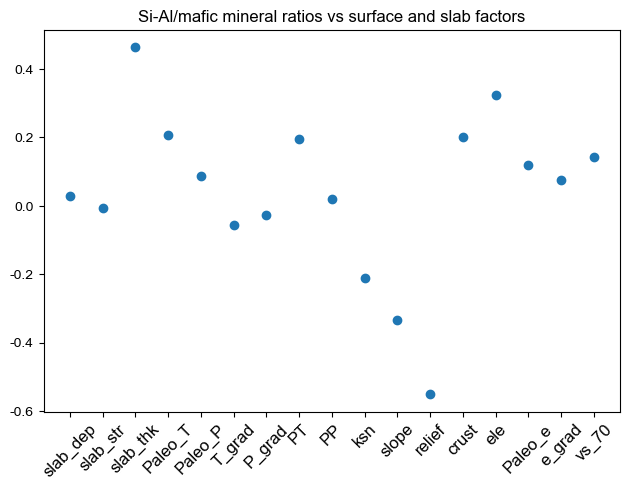

In [14]:

attributes = ['ratios', 'slab_dep', 'slab_str', 'slab_thk', 'Paleo_T', 'Paleo_P', \
              'T_grad', 'P_grad', 'PT', 'PP', 'ksn', 'slope', 'relief', 'crust', 'ele', 'Paleo_e', 'e_grad', 'vs_70']
#cor_matrix = point_sr[attributes][(point_sr['System'] == 'AHe' )|(point_sr['System']== 'AFT')].corr()    
cor_matrix = point_sr[attributes][(point_sr['analyze']== 1 )].corr()

matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams["axes.unicode_minus"] = False

plt.scatter(attributes[1:], cor_matrix['ratios'].iloc[1:])
plt.xticks(ticks=range(len(attributes[1:])), 
           labels= attributes[1:], rotation=45, fontsize = 12)
plt.tight_layout()
plt.title("Si-Al/mafic mineral ratios vs surface and slab factors")
plt.show()


In [21]:
#####PCA biplot
filtered_data = point_sr[attributes]
filtered_data = filtered_data.dropna()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(filtered_data)

scaled_data = pd.DataFrame(scaled_data, columns = attributes)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_


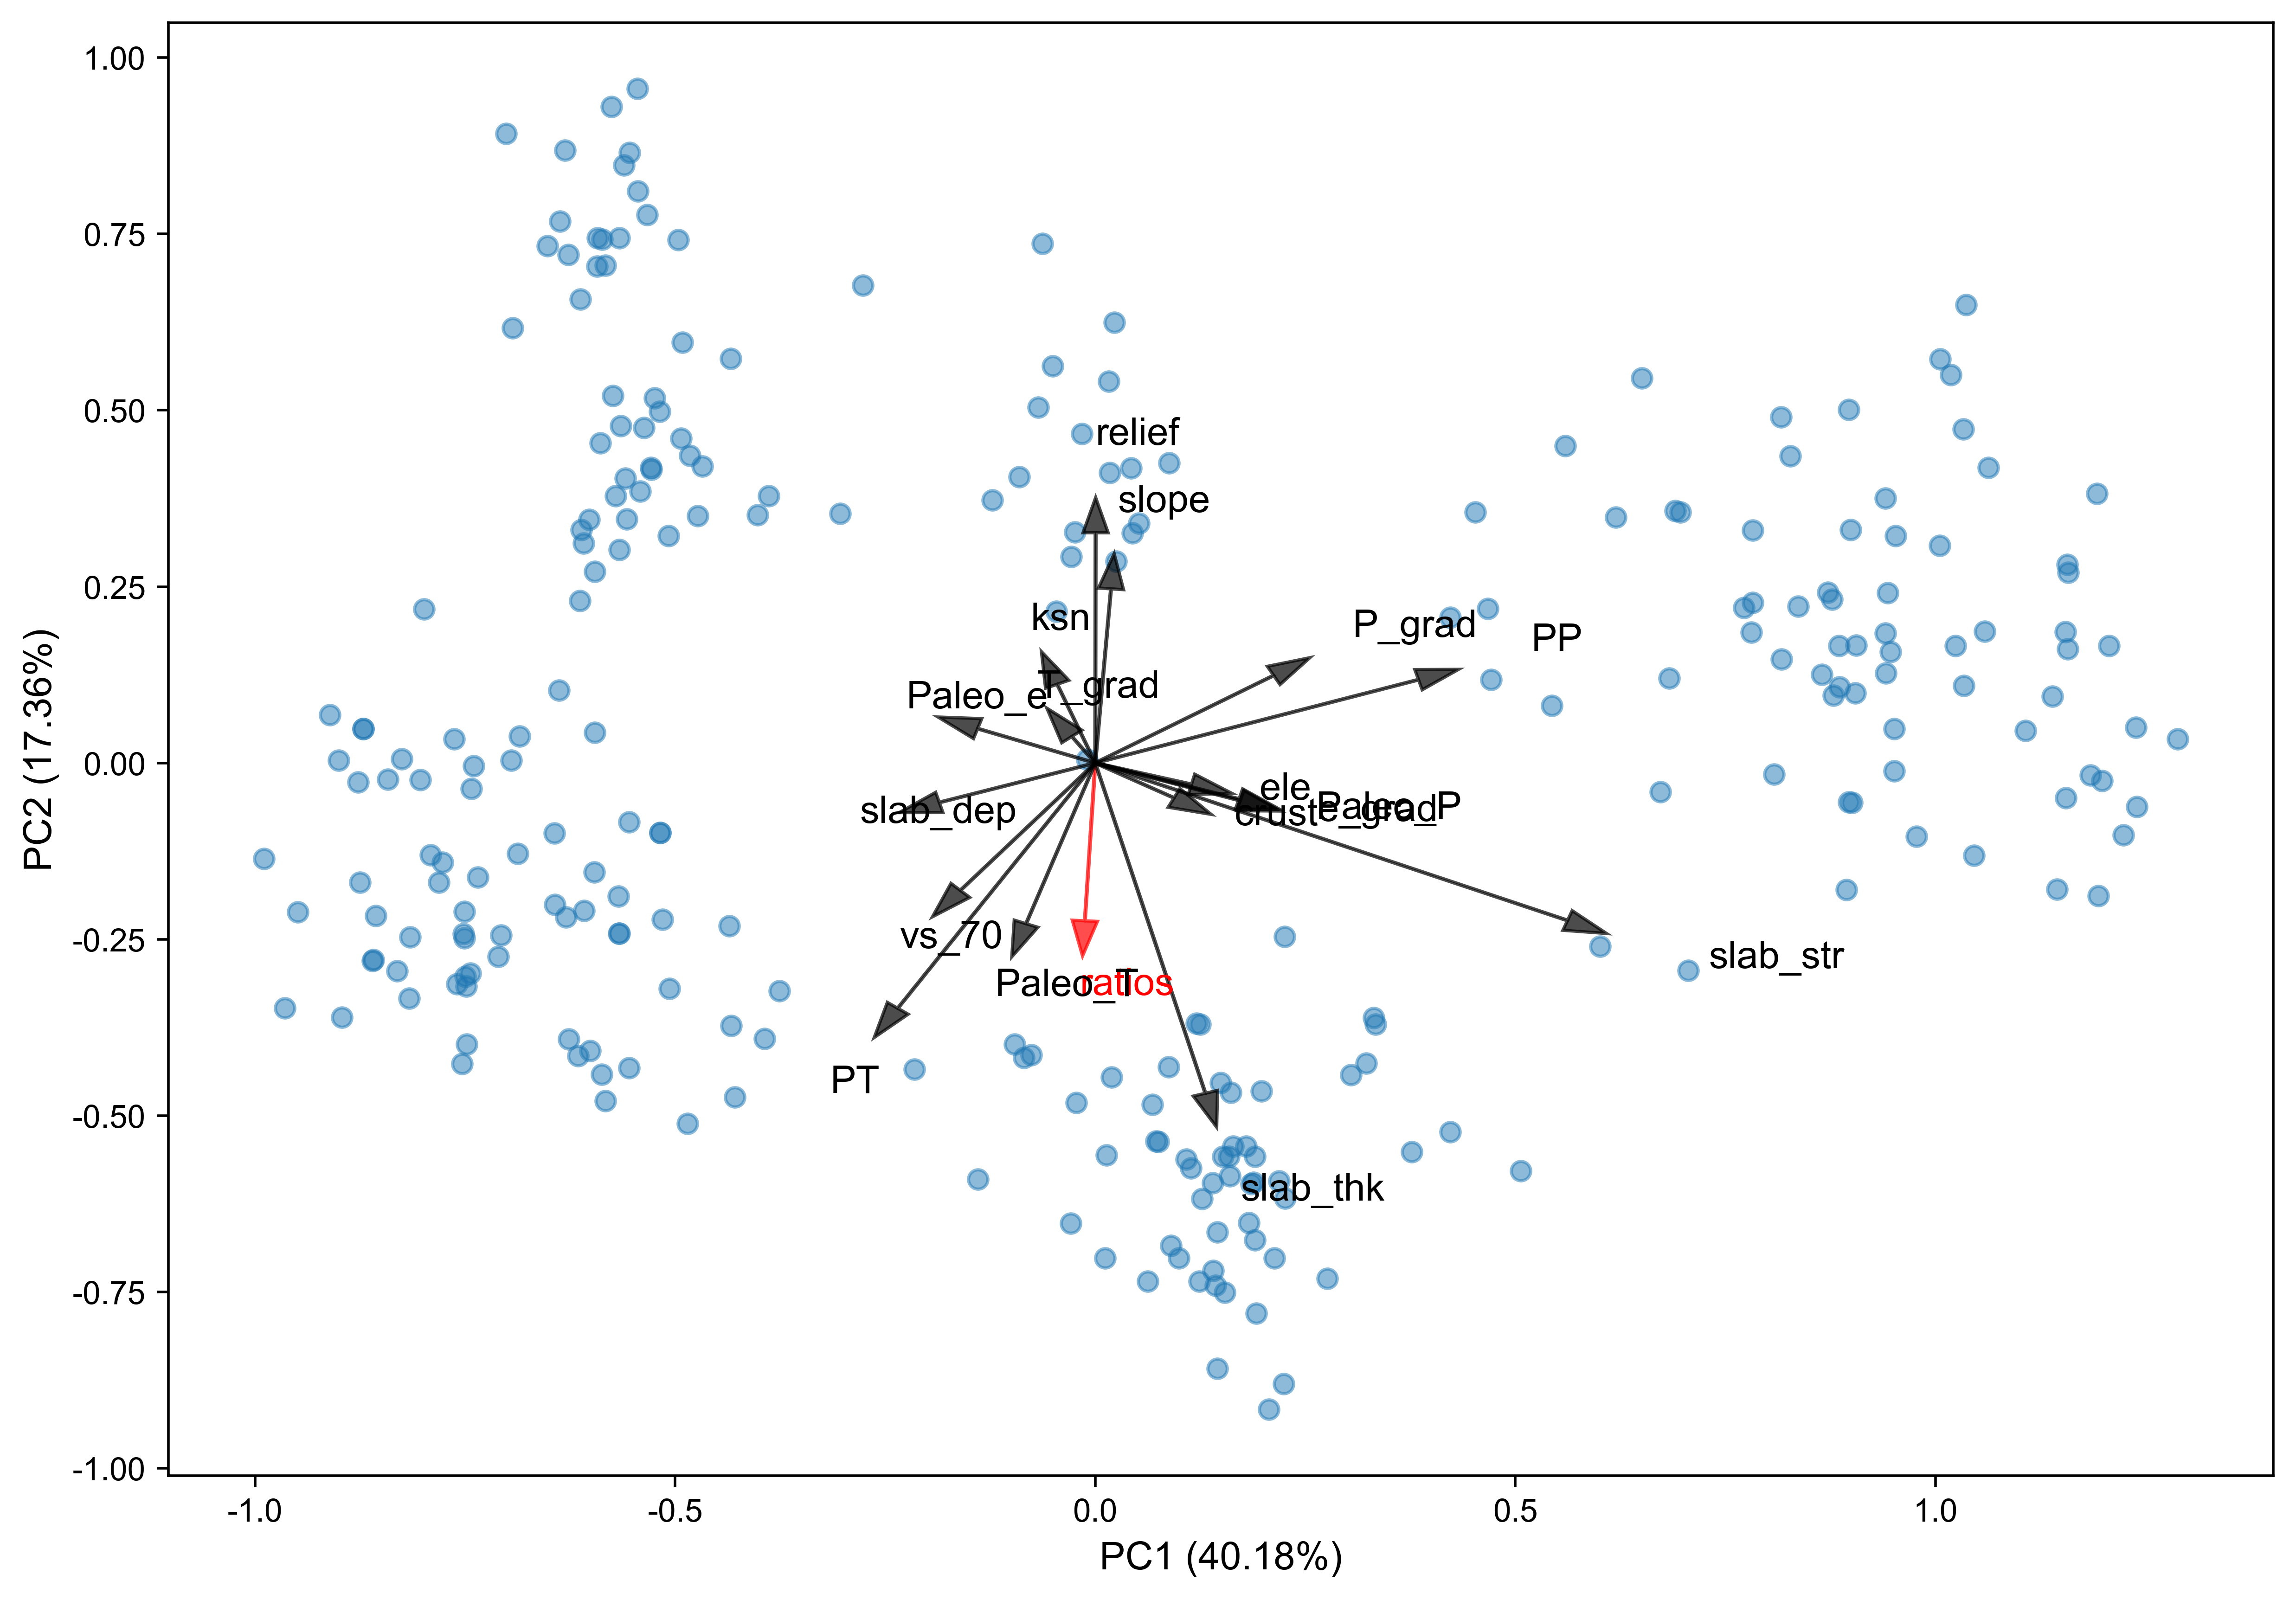

In [22]:
# # Create the biplot
plt.figure(figsize=(10, 7), dpi = 500)

# # Scatter plot of samples
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha = 0.5, label='Samples')


# # Add vectors for each attribute
for i, attribute in enumerate(attributes):
    if attribute == 'ratios':
        plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
               color='r', alpha=0.7, head_width=0.03, head_length = 0.05, length_includes_head=True)
        plt.text(pca.components_[0, i]*1.2, pca.components_[1, i]*1.2, 
             attribute, color='r', fontsize=12)
    else:
        plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
               color='k', alpha=0.7, head_width=0.03, head_length = 0.05, length_includes_head=True)
        plt.text(pca.components_[0, i]*1.2, pca.components_[1, i]*1.2, 
             attribute, color='k', fontsize=12)


# # Customize the plot
plt.xlabel(f"PC1 ({explained_variance[0]*100:.2f}%)", fontsize = 12)
plt.ylabel(f"PC2 ({explained_variance[1]*100:.2f}%)", fontsize =12 )
#plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
#plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)

plt.tight_layout()
#plt.savefig("D:\\Andes\\png\\PCA.svg", dpi = 600)
plt.show()

ratios      1.000000
slab_dep    0.061207
slab_str   -0.160278
slab_thk    0.437980
Paleo_T     0.335822
Paleo_P     0.062887
T_grad     -0.250556
P_grad     -0.114594
PT          0.286461
PP         -0.097456
ksn        -0.296958
slope      -0.418820
relief     -0.583954
crust       0.115470
ele         0.219434
Paleo_e     0.001132
e_grad      0.096957
vs_70       0.226195
Name: ratios, dtype: float64


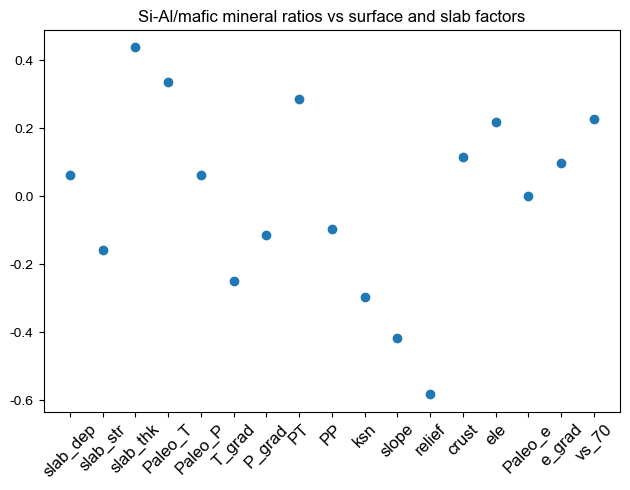

In [23]:
# Compute Spearman's correlation
spearman_corr = filtered_data[attributes].corr(method='spearman')
print(spearman_corr['ratios'])

plt.scatter(attributes[1:], spearman_corr['ratios'].iloc[1:])
plt.xticks(ticks=range(len(attributes[1:])), 
           labels= attributes[1:], rotation=45, fontsize = 12)
plt.tight_layout()
plt.title("Si-Al/mafic mineral ratios vs surface and slab factors")
plt.show()

In [24]:
AlOH_spear = pd.concat(
    [filtered_data.iloc[:, 1:], 
     point_sr.loc[point_sr['analyze'] == 1, ['focal_Al_1']]], 
    axis=1
)
AlOH_spear = AlOH_spear.corr(method = 'spearman')
print(AlOH_spear['focal_Al_1'])

slab_dep      0.123874
slab_str     -0.150284
slab_thk      0.420639
Paleo_T       0.475118
Paleo_P      -0.064090
T_grad       -0.152859
P_grad       -0.235858
PT            0.471740
PP           -0.135443
ksn          -0.105421
slope        -0.248473
relief       -0.437437
crust         0.252742
ele           0.241884
Paleo_e      -0.066685
e_grad        0.147155
vs_70         0.177318
focal_Al_1    1.000000
Name: focal_Al_1, dtype: float64


In [25]:
T_depth_spear = pd.concat(
    [filtered_data.iloc[:, 1:], 
     point_sr.loc[point_sr['analyze'] == 1, ['Focal_T_de']]], 
    axis=1
)

T_depth_spear = T_depth_spear.corr(method = 'spearman')
print(T_depth_spear['Focal_T_de'])

slab_dep     -0.041253
slab_str     -0.079484
slab_thk      0.426837
Paleo_T       0.283534
Paleo_P       0.069110
T_grad       -0.156939
P_grad       -0.079505
PT            0.290747
PP           -0.036900
ksn          -0.296757
slope        -0.357327
relief       -0.569885
crust         0.183714
ele           0.283571
Paleo_e      -0.001397
e_grad        0.109453
vs_70         0.180486
Focal_T_de    1.000000
Name: Focal_T_de, dtype: float64


In [26]:
Mg_depth_spear = pd.concat(
    [filtered_data.iloc[:, 1:], 
     point_sr.loc[point_sr['analyze'] == 1, ['Focal_MgOH']]], 
    axis=1
)
Mg_depth_spear = Mg_depth_spear.corr(method = 'spearman')

print(Mg_depth_spear['Focal_MgOH'])

slab_dep      0.285249
slab_str     -0.162531
slab_thk     -0.506578
Paleo_T      -0.007916
Paleo_P      -0.297611
T_grad        0.009033
P_grad       -0.112734
PT           -0.088355
PP           -0.318631
ksn           0.166622
slope         0.266559
relief        0.392388
crust        -0.336754
ele          -0.311994
Paleo_e       0.043754
e_grad       -0.229496
vs_70         0.157007
Focal_MgOH    1.000000
Name: Focal_MgOH, dtype: float64


In [27]:
MI_depth_spear = pd.concat(
    [filtered_data.iloc[:, 1:], 
     point_sr.loc[point_sr['analyze'] == 1, ['Focal_MI2']]], 
    axis=1
)
MI_depth_spear = MI_depth_spear.corr(method = 'spearman')

print(MI_depth_spear['Focal_MI2'])

slab_dep     0.118043
slab_str     0.039924
slab_thk    -0.480696
Paleo_T     -0.273823
Paleo_P     -0.103043
T_grad       0.171654
P_grad       0.034240
PT          -0.283240
PP          -0.043726
ksn          0.298193
slope        0.340985
relief       0.569215
crust       -0.247457
ele         -0.400284
Paleo_e      0.017360
e_grad      -0.176683
vs_70       -0.180940
Focal_MI2    1.000000
Name: Focal_MI2, dtype: float64


In [28]:
corrs = pd.concat([
    spearman_corr['ratios'], AlOH_spear['focal_Al_1'], T_depth_spear['Focal_T_de'],MI_depth_spear['Focal_MI2'], Mg_depth_spear['Focal_MgOH']
    
], axis = 1)

In [29]:
corrs= corrs.dropna(axis = 0)
corrs

,ratios,focal_Al_1,Focal_T_de,Focal_MI2,Focal_MgOH
slab_dep,0.061207,0.123874,-0.041253,0.118043,0.285249
slab_str,-0.160278,-0.150284,-0.079484,0.039924,-0.162531
slab_thk,0.437980,0.420639,0.426837,-0.480696,-0.506578
Paleo_T,0.335822,0.475118,0.283534,-0.273823,-0.007916
Paleo_P,0.062887,-0.064090,0.069110,-0.103043,-0.297611
T_grad,-0.250556,-0.152859,-0.156939,0.171654,0.009033
P_grad,-0.114594,-0.235858,-0.079505,0.034240,-0.112734
PT,0.286461,0.471740,0.290747,-0.283240,-0.088355
PP,-0.097456,-0.135443,-0.036900,-0.043726,-0.318631
ksn,-0.296958,-0.105421,-0.296757,0.298193,0.166622


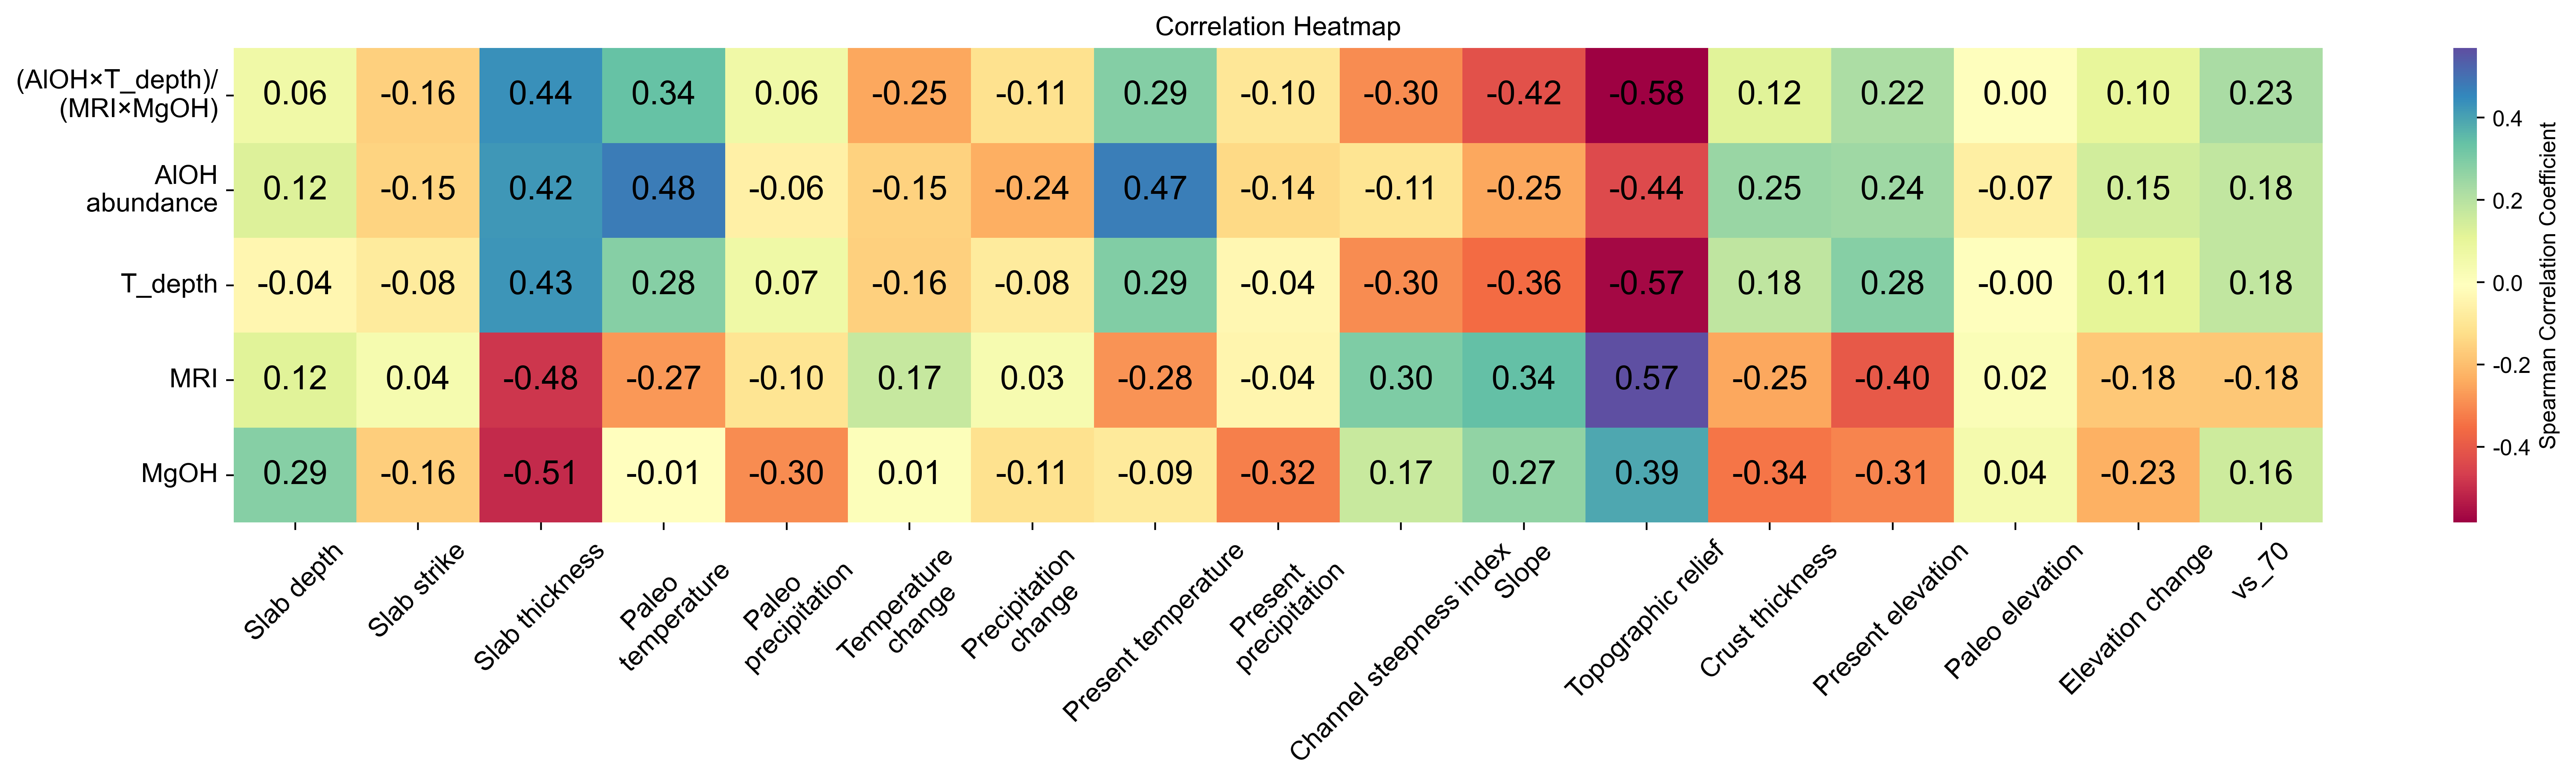

In [38]:
plt.figure(figsize=(18, 5), dpi=400)
sns.heatmap(corrs.T, annot=True, fmt='.2f', cmap='Spectral', cbar_kws={'label': 'Spearman Correlation Coefficient'}, 
            annot_kws = {'color': 'black', 'weight': 'normal', 'fontsize':15}) 

#Customize the plot
plt.yticks(ticks=np.arange(len(corrs.columns))+0.5, rotation = 0, labels=['(AlOH×T_depth)/\n(MRI×MgOH)', 'AlOH\n abundance', \
                                                              'T_depth', 'MRI', 'MgOH'], ha='right', fontsize = 12)
plt.xticks(ticks = np.arange(len(corrs.index))+0.5,
           rotation=45, fontsize = 12, labels = [ 'Slab depth', 'Slab strike', 'Slab thickness', 'Paleo \n temperature',
                                              'Paleo \n precipitation', 'Temperature \n change', 'Precipitation \n change',
                                              'Present temperature', 'Present\n precipitation', 'Channel steepness index', 'Slope', 'Topographic relief',\
                                               'Crust thickness', 'Present elevation', 'Paleo elevation' , 'Elevation change', 'vs_70'])
plt.title("Correlation Heatmap")
plt.tight_layout()

plt.show()

In [39]:
filtered_data.columns
X = filtered_data[attributes[1:]].dropna()
print(X.columns)
y = filtered_data['ratios'].dropna()

Index(['slab_dep', 'slab_str', 'slab_thk', 'Paleo_T', 'Paleo_P', 'T_grad',
       'P_grad', 'PT', 'PP', 'ksn', 'slope', 'relief', 'crust', 'ele',
       'Paleo_e', 'e_grad', 'vs_70'],
      dtype='object')


In [40]:
# subset features according to correlation analysis
X = X[ ['vs_70', 'slab_str', 'slab_thk', 'Paleo_T', 'PT','T_grad', 'ksn', 'slope', 'relief', 'ele']  ]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(53,)
(210, 10)
(210,)


In [42]:
# Fit Random Forest model with RFECV
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

rf_model = RandomForestRegressor(n_estimators =500, random_state=42, min_samples_split = 2)


scores = []
corr_val = []
rmse = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    rf_model.fit(X_train, y_train)
    

    y_pred = rf_model.predict(X_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    scores.append(r2_score(y_test, y_pred))
    corr_val.append(np.corrcoef(y_pred, y_test))

# Plot feature importance
mean_ac = np.mean(scores)
mean_corr = np.mean(corr_val)
mean_rmse = np.mean(rmse)

print(mean_ac )
print(mean_corr)
print(mean_rmse)


0.6919105440876627
0.9178939834653083
12.133909579317192


In [44]:
explainer =shap.Explainer(rf_model)
shp_values = explainer.shap_values(X)

In [45]:
shap_df = pd.DataFrame(shp_values, columns = X.columns)
shap_df.head()


,vs_70,slab_str,slab_thk,Paleo_T,PT,T_grad,ksn,slope,relief,ele
0,-0.562549,-0.952914,-3.263344,0.330899,-1.209926,-0.423065,-0.731172,0.369764,-1.300922,0.077300
1,1.509072,-0.735737,-8.060465,0.570472,0.479631,0.143009,0.686069,-0.416297,4.591346,0.111561
2,-0.443165,-1.187602,-4.552292,0.039714,0.943493,0.394825,-0.506685,-0.891332,-3.505792,0.181373
3,1.728855,-1.099400,-6.352761,-0.004115,0.968914,0.343318,-0.490027,-1.233567,-2.916612,0.157232
4,-0.446585,-1.158156,-3.314741,0.230184,0.877291,-0.209835,-0.570809,0.673132,-3.493100,0.155808


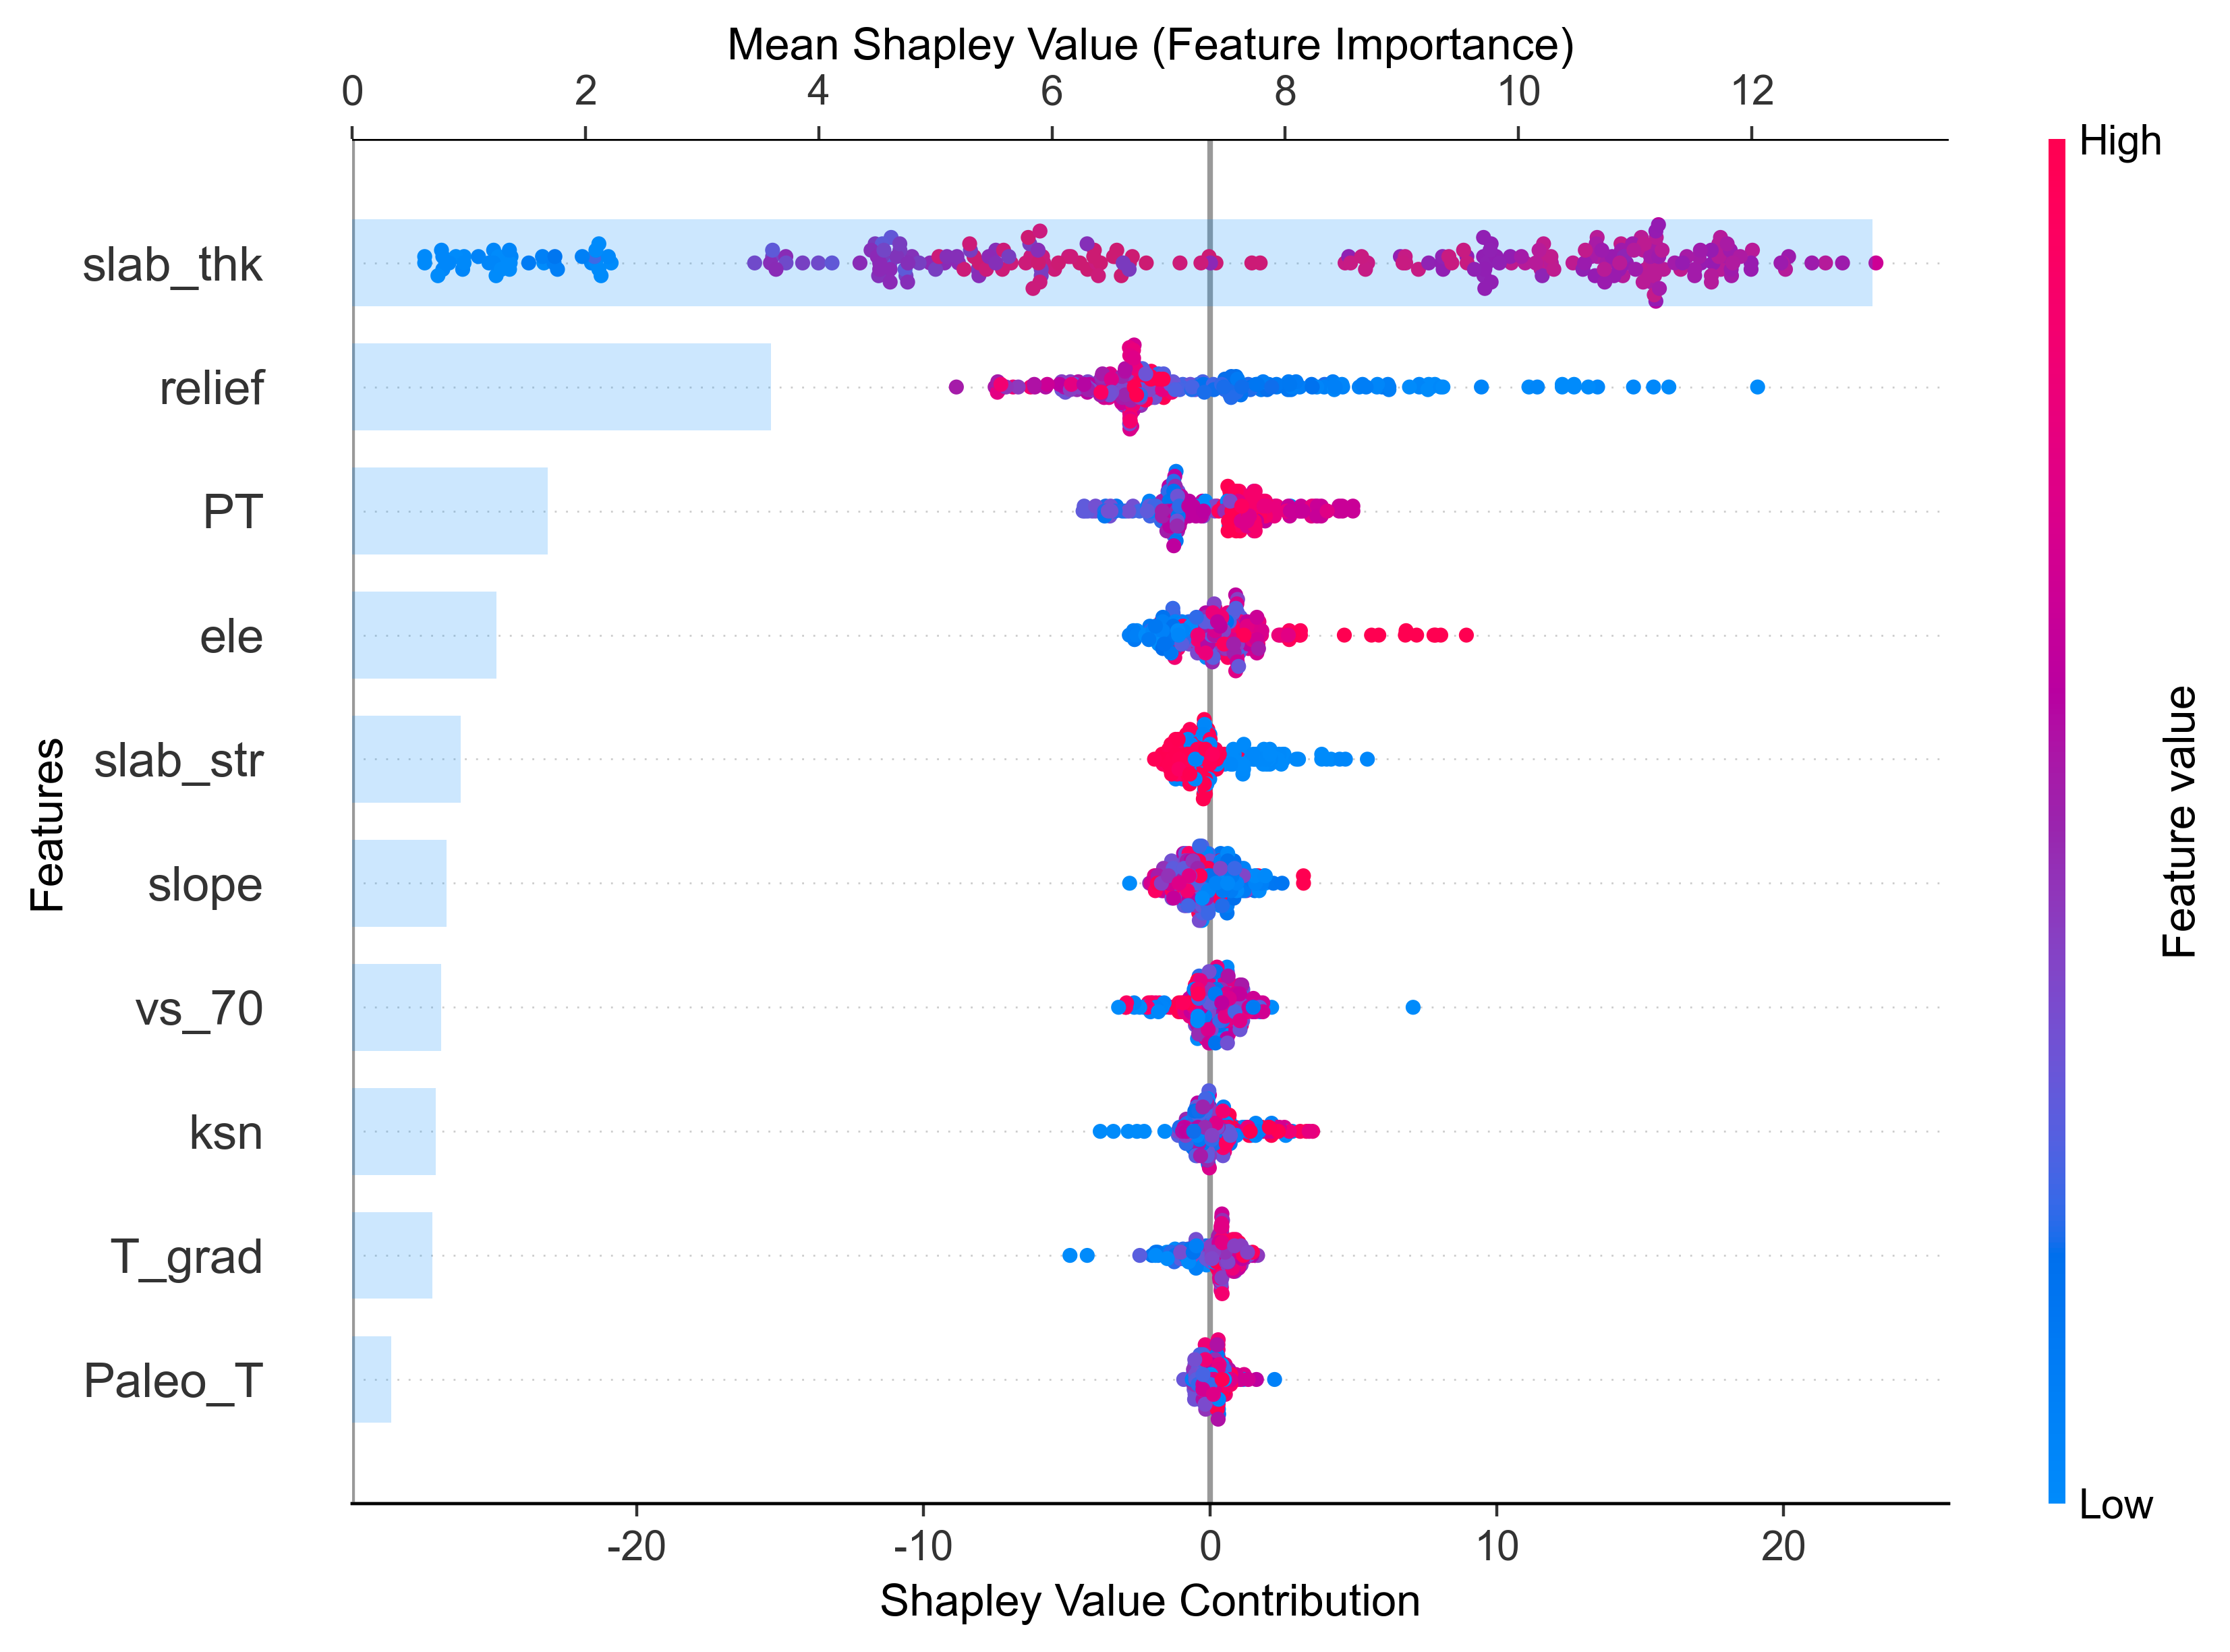

In [46]:
fig, ax1 = plt.subplots(figsize = (10, 8), dpi = 400)
shap.summary_plot(shp_values, X, show = False , plot_type = 'dot')
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])
ax1 = plt.gca()
ax2 = ax1.twiny()
shap.summary_plot(shp_values, X, plot_type="bar", show=False)
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])
ax2.axhline(y=10, color='black', linestyle='-', linewidth=1) 
bars = ax2.patches
for bar in bars:
    bar.set_alpha(0.2)
ax1.set_xlabel('Shapley Value Contribution', fontsize=12)
ax2.set_xlabel('Mean Shapley Value (Feature Importance)', fontsize=12)
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax1.set_ylabel('Features', fontsize=12)
plt.tight_layout()

plt.show()

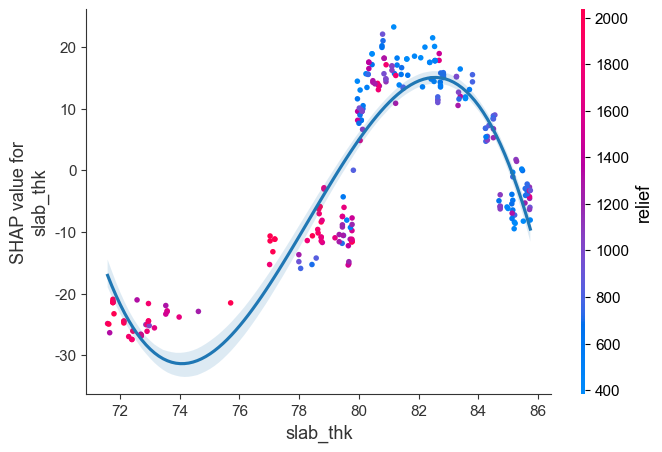

In [47]:

shap.dependence_plot('slab_thk', shap_values = shp_values, features = filtered_data[X.columns], show = False, 
                     interaction_index = 'relief') 
#
ax = plt.gca()  # Get the current axis
feature_values = ax.collections[0].get_offsets()[:, 0]  # Feature values (slab_thk)
shap_values_plot = ax.collections[0].get_offsets()[:, 1]  # SHAP values

degree = 3

sns.regplot(
    x=feature_values, 
    y=shap_values_plot, 
    order=degree,  # Polynomial degree
    ci=95,  # 95% confidence interval
    scatter=False,  # Don't plot the scatter points (already plotted by SHAP)
      # Color of the regression line
    line_kws={'label': f'Polynomial Fit (Degree {degree})'}  # Label for the legend
)

plt.show()

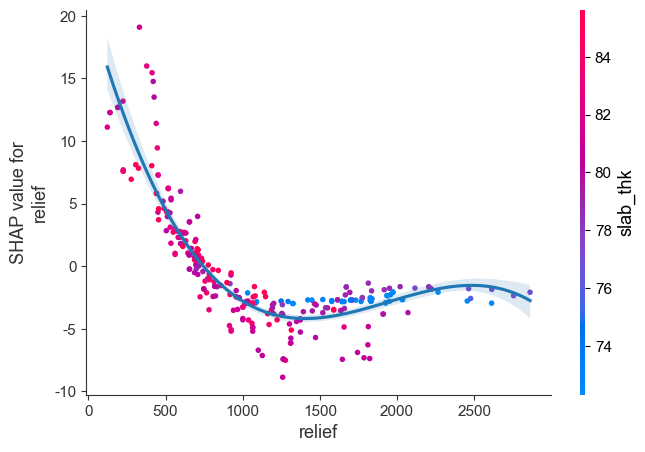

In [48]:
shap.dependence_plot('relief', shap_values = shp_values, features = filtered_data[X.columns], show = False, 
                     interaction_index = 'slab_thk')

ax = plt.gca()  # Get the current axis
feature_values = ax.collections[0].get_offsets()[:, 0]  # Feature values (slab_thk)
shap_values_plot = ax.collections[0].get_offsets()[:, 1]  # SHAP values

degree = 3

sns.regplot(
    x=feature_values, 
    y=shap_values_plot, 
    order=degree,  # Polynomial degree
    ci=95,  # 95% confidence interval
    scatter=False,  # Don't plot the scatter points (already plotted by SHAP)
      # Color of the regression line
    line_kws={'label': f'Polynomial Fit (Degree {degree})'}  # Label for the legend
)

plt.show()